### Compute and store filtered and demodulated velocity fields at each grid point

In [1]:
import numpy as np
import geopandas as gpd

import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from scipy import signal
import scipy.ndimage as im

from sympy import Symbol, pi, atan, factor, lambdify


import mitequinox.plot as pl
import mitequinox.sigp as sp

from fsspec.implementations.local import LocalFileSystem

In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster(processes=1, cores=1,walltime='04:00:00') #processes=7, cores=7
w = cluster.scale(jobs=15
                 )
client = Client(cluster)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.18:8787/status,
Dashboard: http://10.148.0.18:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.18:45203,Workers: 0
Dashboard: http://10.148.0.18:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
def convolve(x, h=None, hilbert=False):
    """ Convolve an input signal with a kernel
    Optionaly compute the Hilbert transform of the resulting time series
    
    Parameters
    x : input signal
    h : filter 
    hilbert : True for Hilbert transform to be applied to the filtered signal
    
    Returns
    x_f : filtered signal or hilbert transform of the filtered signal
    """
    x_f = signal.filtfilt(h, [1], x, axis=-1,padlen=0)#
    if hilbert:
        return signal.hilbert(x_f)
    else:
        return x_f

def filt(v, h, hilbert=False):
    
    output_dtype = complex if hilbert else float
    gufunc_kwargs = dict(output_sizes={'time': len(v.time)})
    return xr.apply_ufunc(convolve, v, kwargs={'h': h, 'hilbert': hilbert},
                    dask='parallelized', output_dtypes=[output_dtype],
                    input_core_dims=[['time']],
                    output_core_dims=[['time']],
                    dask_gufunc_kwargs = gufunc_kwargs,
                         )

##### First step : Filter and demodulate for each face

In [5]:
# Load Eulerian fields
ds =  xr.open_zarr(ut.work_data_dir+'rechunked/SSU_rot.zarr',consolidated=False)
grd = ut.load_grd(consolidated=False)[['XC', 'YC', 'Depth']]#.persist()

In [6]:
#isel=dict(face=12) #face
#V = ['SSV_rot']#'zonal_velocity','meridional_velocity'
path = '/home1/datawork/zcaspar/mit4320/filtered_itide/'
dsel = 200

In [7]:
dt = 1/24 # time step in days

tidal_omega = sp.get_tidal_frequencies("M2", "K2","S2","N2")
omega_M2,omega_S2,omega_N2,omega_K2, domega, name = tidal_omega["M2"],tidal_omega["S2"],tidal_omega["N2"],tidal_omega["K2"], .2, "semidiurnal"
omega = (omega_M2+omega_S2)/2#center frequency
Tw = 30 #filter length
dband = 0.2 # half-bandwidth
V = ['SSU_rot']

In [8]:
#dt = 1. # in hours
#T = 20
#omega = 1/30
#h = signal.firwin(T*24, cutoff=[omega], pass_zero=True, nyq=1./2/dt, scale=True)
#V = 'SSU_rot'

In [9]:
import dask
def wrap_filter(_ds,dt=dt):
    h = sp.generate_filter(om, T=Tw, dt=dt, bandwidth=dband, normalized_bandwidth=None)
    time = np.arange(0,_ds['time'].values.size*dt,dt)
    exp = np.exp(-1j*om*2*np.pi*time)
#    _ds = ut._reset_chunk_encoding(_ds)
    _ds = _ds.chunk(dict(time=-1,i=100,j=100))
    ds_hat={}
    for v in V:
        ds_hat[v+'_hat'] = filt(_ds[v], h,hilbert=False)#.persist()
        ds_hat[v+'_hat_real'] = ds_hat[v+'_hat'].real
        ds_hat[v+'_hat_imag'] = ds_hat[v+'_hat'].imag
#        ds_hat[v+'_hat'] = ds_hat[v+'_hat'].assign_coords({'lon':ds_hat[v+'_hat'].lon,'lat':ds_hat[v+'_hat'].lat})
#        ds_hat[v+'_demodulated'] = ds_hat[v+'_hat']*exp
#        ds_hat[v+'_demodulated_real'] = ds_hat[v+'_demodulated'].real
#        ds_hat[v+'_demodulated_imag'] = ds_hat[v+'_demodulated'].imag
    ds_hat = xr.merge([ds_hat[v].rename(v) for v in ds_hat.keys()])#.drop([v+'_hat',v+'_demodulated'])
#    ds_hat = ds_hat.chunk(dict(i=100)) #,j=4320//4
    ds_hat = ut._reset_chunk_encoding(ds_hat)
    return ds_hat#.drop(['XC','YC'])

def wrap_filter_low(_ds,dt=dt):
    h = signal.firwin(T*24, cutoff=[omega], pass_zero=True, nyq=1./2/dt, scale=True)
    ds_hat = filt(_ds[v], h,hilbert=False)#.persist()
    ds_hat = ds_hat.rename(v+'_hat').to_dataset()
#    ds_hat = ds_hat.chunk(dict(i=4320//4,j=4320//4))
#    ds_hat = ut._reset_chunk_encoding(ds_hat)
    return ds_hat

In [10]:
def wrap_demodulation(ds_hat,dt=dt):
#    time = np.arange(0,ds_hat['time'].values.size*dt,dt)
    exp = np.exp(-1j*om*2*np.pi*time)

#    _ds = ut._reset_chunk_encoding(_ds)
#    _ds = _ds.chunk(dict(time=16,i=100,j=100))
#    ds_hat={}
    for v in V:
#        ds_hat[v+'_hat'] = ds_hat[v+'_hat_real']+1j*ds_hat[v+'_hat_imag']
#        ds_hat[v+'_hat'] = ds_hat[v+'_hat'].assign_coords({'lon':ds_hat[v+'_hat'].lon,'lat':ds_hat[v+'_hat'].lat})
        ds_hat[v+'_demodulated'] = ds_hat[v+'_hat']*exp
        ds_hat[v+'_demodulated_real'] = ds_hat[v+'_demodulated'].real
        ds_hat[v+'_demodulated_imag'] = ds_hat[v+'_demodulated'].imag
    ds_hat = xr.merge([ds_hat[v].rename(v) for v in ds_hat.keys()]).drop([v+'_demodulated',v+'_hat'])
 #   ds_hat = ds_hat.chunk(dict(i=100)) #,j=4320//4
    
    return ds_hat#.drop(['XC','YC'])

In [11]:
#Select and rechunk (empirical) original dataset
isel = dict(face=slice(0,2))#dict(j=slice(3800,None))#j=slice(0,4320//10))
dsp = ds.isel(**isel)#.isel(i=slice(4,None,4),j=slice(4, None,4))#.isel(face=0)#.sel(**sel)#.persist()
dsp = dsp.chunk({"time": -1})#.persist()#,'i':100,'j':70
dsp

<xarray.Dataset>
Dimensions:  (face: 2, j: 4320, i: 4320, time: 8640)
Coordinates:
  * face     (face) int64 0 1
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * time     (time) datetime64[ns] 2011-11-15 ... 2012-11-08T23:00:00
Data variables:
    CS       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    SN       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    SSU_rot  (time, face, j, i) float32 dask.array<chunksize=(8640, 1, 192, 576), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    rA       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>

In [10]:
dsp =  xr.open_zarr(ut.work_data_dir+'filtered_itide/SSU_filtered_3800.zarr',consolidated=False)#.isel(face=slice(1,None))
dsp

,Array,Chunk
Bytes,1.84 TiB,659.18 MiB
Shape,"(13, 520, 4320, 8640)","(1, 100, 100, 8640)"
Count,3433 Tasks,3432 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,1.84 TiB,659.18 MiB
Shape,"(13, 520, 4320, 8640)","(1, 100, 100, 8640)"
Count,3433 Tasks,3432 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [11]:
time = np.arange(0,dsp['time'].values.size*dt,dt)

In [12]:
dsp#.isel(face=0)[V[0]+'_hat']

,Array,Chunk
Bytes,1.84 TiB,659.18 MiB
Shape,"(13, 520, 4320, 8640)","(1, 100, 100, 8640)"
Count,3433 Tasks,3432 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,1.84 TiB,659.18 MiB
Shape,"(13, 520, 4320, 8640)","(1, 100, 100, 8640)"
Count,3433 Tasks,3432 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [12]:
om,Tw,dband,V = omega,Tw,dband,V #define parameters needed in wrap_filter

In [13]:
# Apply wrap_filter on the dataset and store the result for each face (seperated)
import os
#zarr_main = os.path.join(ut.root_data_dir, "filtered_itide/SSU_filtered_face4.zarr")
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds_out, zarr = ut.custom_distribute(dsp, 
                                        wrap_filter,
                                        overwrite=True,
                                        suffix="SSU_filtered_test.zarr",
                                        tmp_dir=os.path.join(ut.root_data_dir, "filtered_itide"),
                                        append=True,
#                                        face=1
                                        j=200
                                       )

0it [02:43, ?it/s]


KeyboardInterrupt: 

In [38]:
ds_out

,Array,Chunk
Bytes,2.35 TiB,26.37 MiB
Shape,"(4320, 4320, 8640)","(100, 1080, 16)"
Count,95041 Tasks,95040 Chunks
Type,complex128,numpy.ndarray
,Array,Chunk
Bytes,2.35 TiB,26.37 MiB
Shape,"(4320, 4320, 8640)","(100, 1080, 16)"
Count,95041 Tasks,95040 Chunks
Type,complex128,numpy.ndarray


In [13]:
ds_out

,Array,Chunk
Bytes,2.82 TiB,659.18 MiB
Shape,"(13, 800, 4320, 8640)","(1, 100, 100, 8640)"
Count,4577 Tasks,4576 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,2.82 TiB,659.18 MiB
Shape,"(13, 800, 4320, 8640)","(1, 100, 100, 8640)"
Count,4577 Tasks,4576 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [15]:
#client.restart()
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


##### Second step : Concat filtered and demodulated fields

In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()

#
from dask_jobqueue import PBSCluster
cluster = PBSCluster(processes=7, cores=7, walltime='04:00:00') #processes=7, cores=7 ,walltime='03:00:00'
w = cluster.scale(jobs=6
                 )
client = Client(cluster)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.238:8787/status,
Dashboard: http://10.148.0.238:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.238:60736,Workers: 0
Dashboard: http://10.148.0.238:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [20]:
ds = xr.concat([xr.open_zarr(ut.work_data_dir+'filtered_itide/SSU_demodulated_%s.zarr'%i, consolidated=False
                            ) for i in [1000,2000,3000]],dim = 'j')#.sel(face=4)#.persist()
#ds = xr.open_zarr(ut.work_data_dir+'filtered_itide/SSU_filtered.zarr')

In [36]:
ds1000 = xr.open_zarr(ut.work_data_dir+'filtered_itide/SSU_demodulated_1000.zarr')

In [37]:
xr.merge([ds,ds1000])

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/array/core.py:4527: PerformanceWarning: Increasing number of chunks by factor of 44
  result = blockwise(
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):


KeyboardInterrupt: 

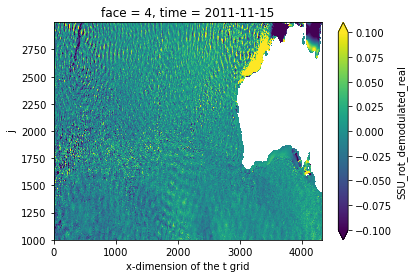

In [29]:
ds.SSU_rot_demodulated_real.isel(face=4,time=0).plot(cmap='viridis',vmax=0.1)

In [23]:
ds = xr.combine_by_coords([xr.open_zarr(ut.work_data_dir+'filtered_itide/SSU_demodulated_%s.zarr'%i
                                       ) for i in [1000,2000]])

In [26]:
ds.SSU_rot_demodulated_real.isel(time=0).plot(vmax=0.1)

KeyboardInterrupt: 

In [11]:
ds = ds.persist()

In [17]:
ds = ds.chunk({'face':-1,'i':1080,'j':1080})
#ds_out = ds.to_zarr(ut.work_data_dir+'filtered_itide/SSU_demodulated_test.zarr')

In [24]:
def merge(ds):
#    _ds = ds.chunk({'j':-1})
#
    _ds = ds
#    _ds = ds.chunk(dict(i=4320//4,j=4320//4)) #,j=4320//4
    
#    _ds = ut._reset_chunk_encoding(_ds)    
    return _ds

In [13]:
def rechunked(ds):
    _ds = ds.chunk({'time':16,'i':4320//4,'j':4320//4})
    _ds = ut._reset_chunk_encoding(_ds)    
    return _ds

In [25]:
#Apply concat function on ds
face = 1
import os, dask
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds_out, zarr = ut.custom_distribute(ds,#xr.merge([ds0,ds1]), 
                                        merge,
                                        overwrite=True,
                                        suffix="SSU_demodulated_face4.zarr",
                                        tmp_dir=os.path.join(ut.root_data_dir, "filtered_itide"),
                                        append=True,
                                        face=face
#                                        j=200
                                        )

0it [00:00, ?it/s]


ValueError: append_dim='face' does not match any existing dataset dimensions {'j': 3400, 'i': 4320, 'time': 8640}

In [7]:
ds_out

,Array,Chunk
Bytes,778.66 GiB,0.98 GiB
Shape,"(2800, 4320, 8640)","(152, 100, 8640)"
Count,837 Tasks,836 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,778.66 GiB,0.98 GiB
Shape,"(2800, 4320, 8640)","(152, 100, 8640)"
Count,837 Tasks,836 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


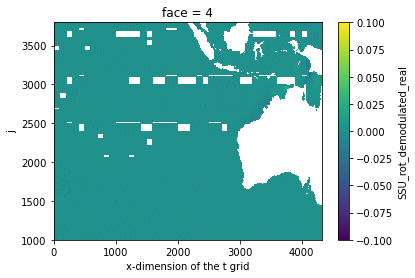

In [10]:
ds_out.SSU_rot_demodulated_real.isel(time=0).plot(cmap='viridis',vmax=0.1)

In [27]:
#client.restart()
#
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
